# Checkerboard Microstructure

## Introduction - What are 2-Point Spatial Correlations (also called 2-Point Statistics)?


This example computes both periodic and non-periodic 2-point spatial correlations (also referred to as 2-point stats or auto-correlations and cross-correlations) for a checkerboard microstructure. This is a simple example to demonstrate how spatial correlations capture features seen in the original microstructure. More technical details about 2-point statistics are in the [theory section](../../THEORY.html).

In [14]:
import numpy as np
from sklearn.pipeline import Pipeline

from pymks import (
    generate_checkerboard,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation
)

In [15]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2-Point Statistics for Checkerboard Microstructure

Generate a microstructure that looks like a 8 x 8 checkerboard. Although this microstructure does not resemble a physical system, it is a good example to develop an intuitive understanding of 2-point statistics.

Create a checkerboard microstructure using the `generate_checkerboard` function.

In [16]:
x_data = generate_checkerboard(
    size=(21 * 8, 21 * 8),
    square_shape=(21, 21)
).persist()

Observe he microstructure using the `plot_microstructures` helper function.

(1, 168, 168)


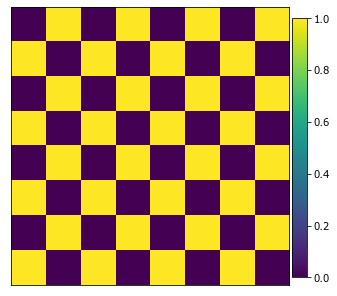

In [17]:
plot_microstructures(x_data[0])
print(x_data.shape)

## Compute Periodic 2-Point Statistics

Compute the periodic 2-points stats using the `TwoPointCorrelation` class. The `periodic_boundary` argument is set to `True`. To compute 2-point stats first discretize the microstructure using a chosen basis using a `PrimitiveTransformer` with `n_state` equal to 2. The `PrimitiveTransformer` and the `TwoPointCorrelation` are combined into a Scikit-learn pipeline to generate a model. The `transform` method executes the pipeline as this is not a model that requires a `predict` step to use. 

In [18]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=True, 
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

print(x_data.shape)
x_stats = model.transform(x_data).persist()
print(x_stats.shape)

(1, 168, 168)
(1, 167, 167, 3)


Plot the auto-correlations.

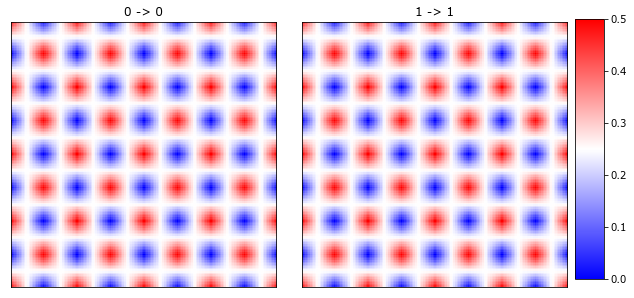

In [19]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');

and then the cross-correlations

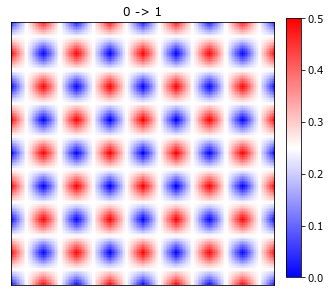

In [20]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');

Notice that for this checkerboard microstructure, the correlations are offset, but with the same values. This is the periodic correlations for a perfectly periodic microstructure with equal volume fractions. In general this is not the case and the correlations will not match the microstructure.

Notice that the crosscorrelation (0 -> 1) is the exact opposite of the autocorrelation (0 -> 0). The (0, 0) vector has a value of 0. This statistic reflects the probablity of 2 phases having the same location. In the checkerboard microstructures, this probability is zero, as we have not allowed the two phases (colored black and white) to co-exist in the same spatial voxel.

Double check that the center points have the correct values.

In [21]:
center = x_stats.shape[1] // 2

print('Volume fraction of 0 -> 0: ', np.allclose(x_stats[0, center, center, 0], 0.5))
print('Volume fraction of 0 -> 1: ', np.allclose(x_stats[0, center, center, 2], 0))

Volume fraction of 0 -> 0:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
Volume fraction of 0 -> 1:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


## Compute Non-Periodic 2-Point Statistics

Compute the non-periodic 2-point statistics for the microstructure, but with non-periodic statistics by setting the `periodic_boundary=False`.

In [22]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=False,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

x_stats = model.transform(x_data).persist()
x_stats.shape

(1, 167, 167, 3)

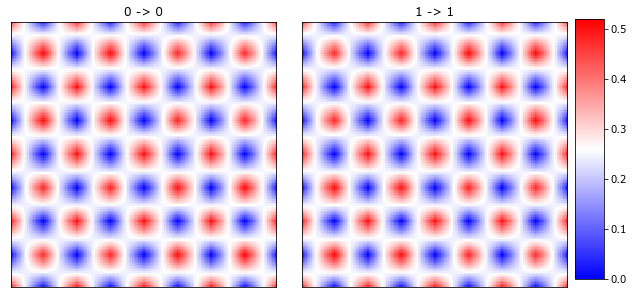

In [23]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');

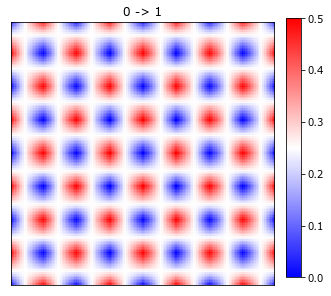

In [24]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');

Notice that the maximum values for the autocorrelations are higher than 0.5 due to the non-periodicity and that the (red -> red) or (blud -> blue) diagonals are more curved compared with the periodic stats.

The centers or the (0, 0) vectors are still equal to the volume fractions.

In [25]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Volume fraction of black phase', x_stats[0, center, center, 0].compute())
print('Volume fraction of white phase', x_stats[0, center, center, 1].compute())

Volume fraction of black phase 0.5
Volume fraction of white phase 0.5


In [26]:
assert np.allclose(x_stats[0, center, center, 0], 0.5)
assert np.allclose(x_stats[0, center, center, 1], 0.5)

The non-periodic statistics are different from the periodic 2-point statistics along the diagonal vectors, but in both cases the probability of (0, 0) vector is still the volume fraction.

## References

[1] S.R. Niezgoda, D.T. Fullwood, S.R. Kalidindi, Delineation of the Space of 2-Point Correlations in a Composite Material System, Acta Materialia, 56, 18, 2008, 5285–5292 [doi:10.1016/j.actamat.2008.07.005](http://dx.doi.org/10.1016/j.actamat.2008.07.005)

 
[2] S.R. Niezgoda, D.M. Turner, D.T. Fullwood, S.R. Kalidindi, Optimized Structure Based Representative Volume Element Sets Reflecting the Ensemble-Averaged 2-Point Statistics, 58, 13, 2010, 4432–4445  [doi:10.1016/j.actamat.2010.04.041](http://dx.doi.org/10.1016/j.actamat.2010.04.041)


[3] D.T. Fullwood, S.R. Kalidindi, and B.L. Adams, Second - Order Microstructure Sensitive Design Using 2-Point Spatial  Correlations, Chapter 12 in Electron Backscatter Diffraction in Materials Science , 2nd Edition , Eds. A. Schwartz, M. Kumar, B. Adams, D. Field, Springer, NY, 2009. 